In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as torch_d
import tikzplotlib

In [15]:
plt.rcParams['figure.dpi'] = 150

In [16]:
class Receiver(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y

class Receiver2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, 128)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(128, 128)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(128, M)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        return self.lin3(y)


class Encoder2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, 128)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(128, M)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        return self.lin2(y)

class Encoder(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M, bias=False)
        nn.init.constant_(self.lin1.weight, 1 / M)

    def forward(self, y):
        return self.lin1(y)

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return nn.functional.one_hot(torch.argmax(input, dim=-1), 8).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [17]:
def gradient_correction_factor(app, idx, prob, M):
    (nn,M)= app.shape
    cf  = torch.zeros(M)
    for j in range(M):
        tmp = app[:, j]
        cf[j] = torch.sum(torch.log(tmp[idx==j])) / (nn*prob[j]) # tmp[idx==j] selects the ll of those xy pairs which belong to the current symbol j
    return cf

In [18]:
def AWGN_channel(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return x + noise_t

In [19]:
M = 8
n = 10_000
nepochs = 4000
lr = 0.001

dec = Receiver2(M)
enc = Encoder2(M)
loss_fn = nn.CrossEntropyLoss()

alphabet = np.arange(-(M-1),M,2)
# alphabet = np.array([-7, -3, -2, -1, 1, 2, 3, 7])
#alphabet = np.array([-10, -6, -3, -1, 1, 3, 6, 10]) <-- Non-uniform alphabet
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
alphabet_t = torch.tensor(alphabet).float()

In [20]:
def sampler(logits, n, M):
    temperature = 10
    estimator = STEFunction.apply
    g_dist = torch_d.Gumbel(loc=torch.tensor([0.]), scale=torch.tensor([1.])) # create Gumbel dist
    g = g_dist.sample(sample_shape=[n, M]).squeeze()
    s_bar = nn.functional.softmax(input=((g + logits) / temperature), dim=1)
    s = estimator(s_bar) # straight through estimator
    return s

def train_encoder_at_dB(dB, report=False):
    SNR_dB = dB
    SNR = 10**(SNR_dB/10)
    sigma2 = 1/SNR

    opt = optim.Adam( list(enc.parameters()) + list(dec.parameters()), lr=lr)

    for j in range(nepochs):
        logits = enc(torch.tensor([1], dtype=torch.float))

        # Sample indexes
        # onehot = sampler(probs, n, M)
        onehot = nn.functional.gumbel_softmax(logits.expand(n, -1), tau=10, hard=True)
        indices = torch.argmax(onehot, dim=1)

        # Modulation
        # with torch.no_grad():
        probs =  nn.functional.softmax(logits, -1)
        norm_factor = torch.rsqrt(torch.sum(torch.pow(torch.abs(alphabet_t), 2) * probs))
        alphabet_norm =  alphabet_t * norm_factor
        symbols = torch.matmul(onehot, torch.transpose(input=alphabet_norm.reshape(1,-1), dim0=0, dim1=1))

        # Channel
        y = AWGN_channel(symbols, sigma2)

        # Demodulator
        ll = dec(y.reshape(-1,1))
        # app = nn.functional.softmax(ll, 1) #Q(X|Y)

        # Loss
        loss = -(torch.sum(-probs*torch.log(probs)) - loss_fn(ll, indices.detach()))# -(H(X) - CE(P,Q)), the gradient descent minimizes, therefore we minimize the opposite to maximize the MI in the end.
        opt.zero_grad()
        loss.backward()

        opt.step()

        # Printout and visualization
        if report and j % 500 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f}')

    if report:
        print('probs: ', probs)
        plt.hist(symbols.detach().numpy(), bins=100)
        plt.show()

    return loss

### Compare Results

In [21]:
def AWGN_channel_np(x, sigma2):
    noise = np.sqrt(sigma2) * np.random.randn(x.size)
    return x + noise

In [22]:
def AWGNdemapper(y, const, varN):
    apps = np.exp(-np.abs(np.transpose([y])-const)**2/(2*varN))
    return apps / np.transpose([np.sum(apps, 1)])

In [23]:
def xesmd(apps, idx):
    """
    Estimates symbolwise equivocation from reference symbols indices and a posteriori probabilities.
    """
    eq = -np.log(np.take_along_axis(apps, idx[:, None], axis=1) / np.transpose([np.sum(apps, 1)]))
    eq[eq==np.inf] = 1000
    return np.mean(eq)

SNR:  5
epoch 0: Loss = 0.0067
epoch 500: Loss = -1.0218
epoch 1000: Loss = -1.0100
epoch 1500: Loss = -1.0194
epoch 2000: Loss = -1.0192
epoch 2500: Loss = -1.0118
epoch 3000: Loss = -1.0072
epoch 3500: Loss = -1.0229
probs:  tensor([0.0502, 0.1000, 0.1549, 0.1947, 0.1953, 0.1570, 0.0983, 0.0497],
       grad_fn=<SoftmaxBackward0>)


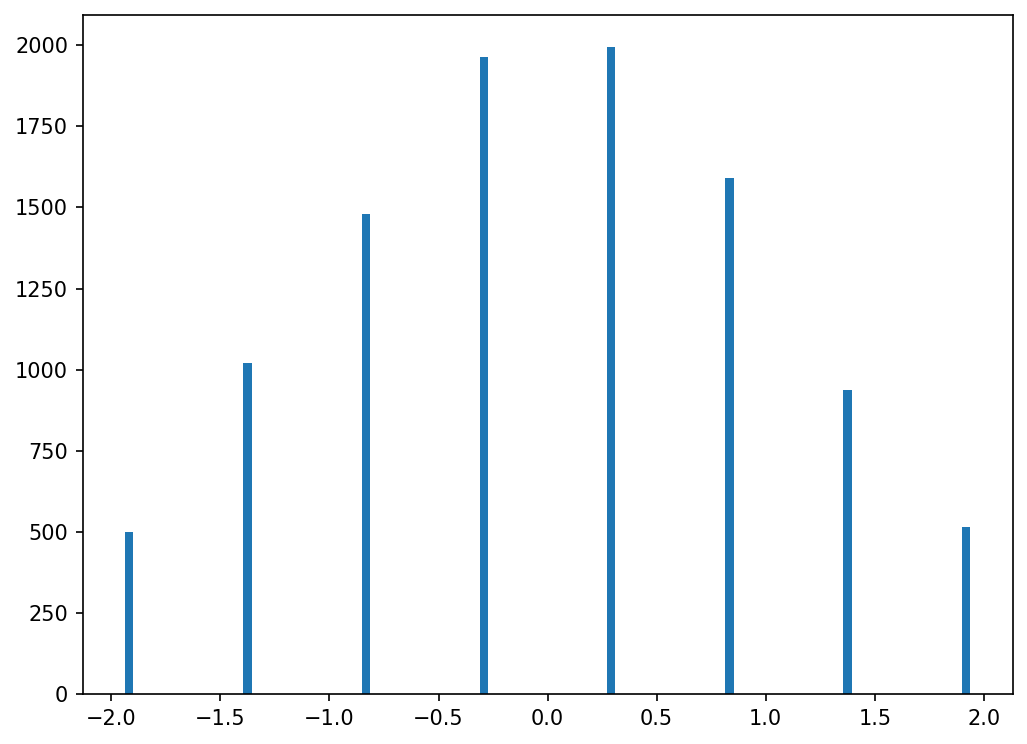

SNR:  6
epoch 0: Loss = -1.1318
epoch 500: Loss = -1.1389
epoch 1000: Loss = -1.1613
epoch 1500: Loss = -1.1575
epoch 2000: Loss = -1.1376
epoch 2500: Loss = -1.1729
epoch 3000: Loss = -1.1437
epoch 3500: Loss = -1.1447
probs:  tensor([0.0449, 0.0957, 0.1586, 0.2025, 0.2023, 0.1565, 0.0948, 0.0448],
       grad_fn=<SoftmaxBackward0>)


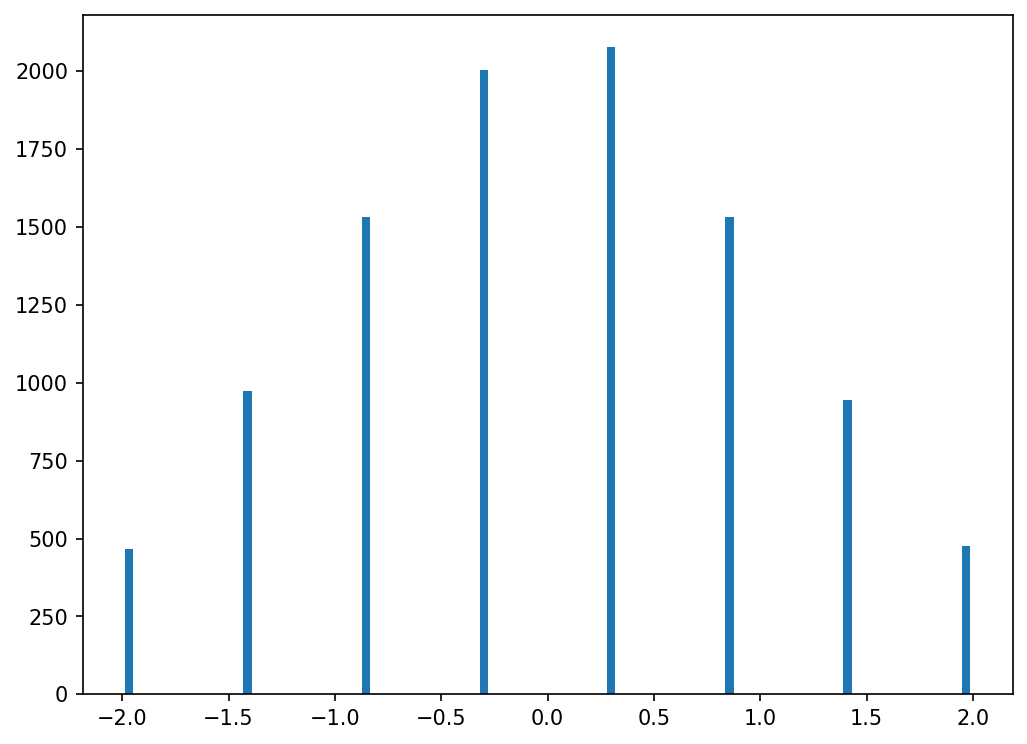

SNR:  7
epoch 0: Loss = -1.2677
epoch 500: Loss = -1.2732
epoch 1000: Loss = -1.2873
epoch 1500: Loss = -1.2775
epoch 2000: Loss = -1.2804
epoch 2500: Loss = -1.2774
epoch 3000: Loss = -1.2876
epoch 3500: Loss = -1.2726
probs:  tensor([0.0396, 0.0914, 0.1596, 0.2103, 0.2097, 0.1583, 0.0913, 0.0397],
       grad_fn=<SoftmaxBackward0>)


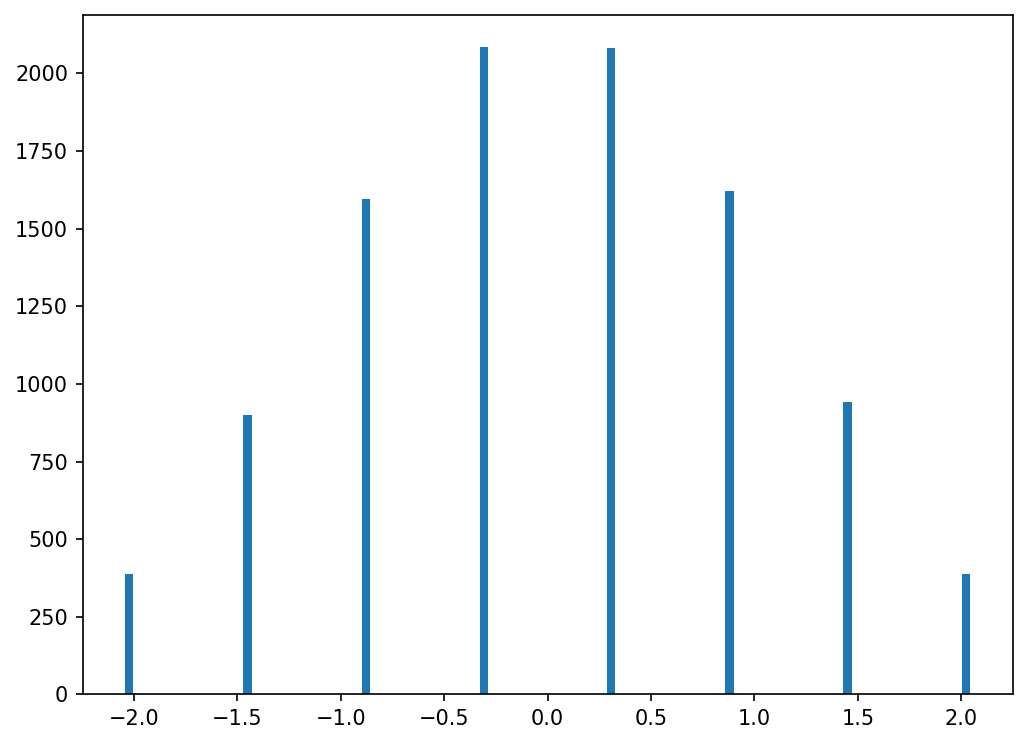

SNR:  8
epoch 0: Loss = -1.4254
epoch 500: Loss = -1.4303
epoch 1000: Loss = -1.4119
epoch 1500: Loss = -1.4254
epoch 2000: Loss = -1.4235
epoch 2500: Loss = -1.4234
epoch 3000: Loss = -1.4301
epoch 3500: Loss = -1.4241
probs:  tensor([0.0351, 0.0874, 0.1614, 0.2171, 0.2171, 0.1594, 0.0874, 0.0351],
       grad_fn=<SoftmaxBackward0>)


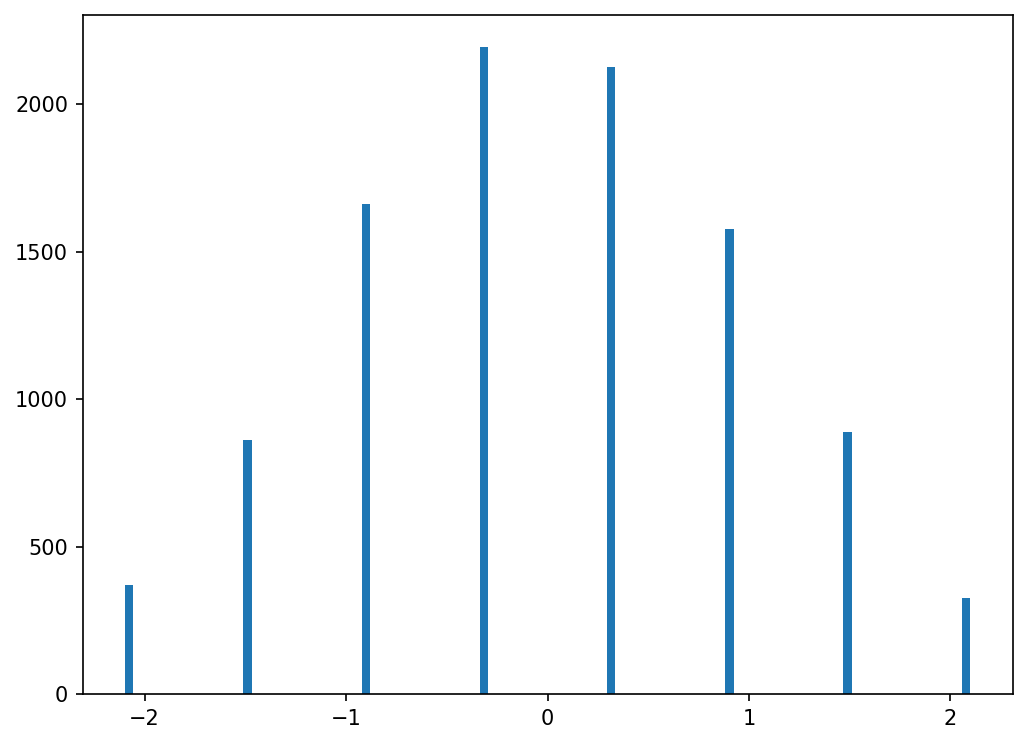

SNR:  9
epoch 0: Loss = -1.5476
epoch 500: Loss = -1.5795
epoch 1000: Loss = -1.5588
epoch 1500: Loss = -1.5739
epoch 2000: Loss = -1.5797
epoch 2500: Loss = -1.5563
epoch 3000: Loss = -1.5850
epoch 3500: Loss = -1.5735
probs:  tensor([0.0305, 0.0827, 0.1615, 0.2259, 0.2256, 0.1613, 0.0823, 0.0302],
       grad_fn=<SoftmaxBackward0>)


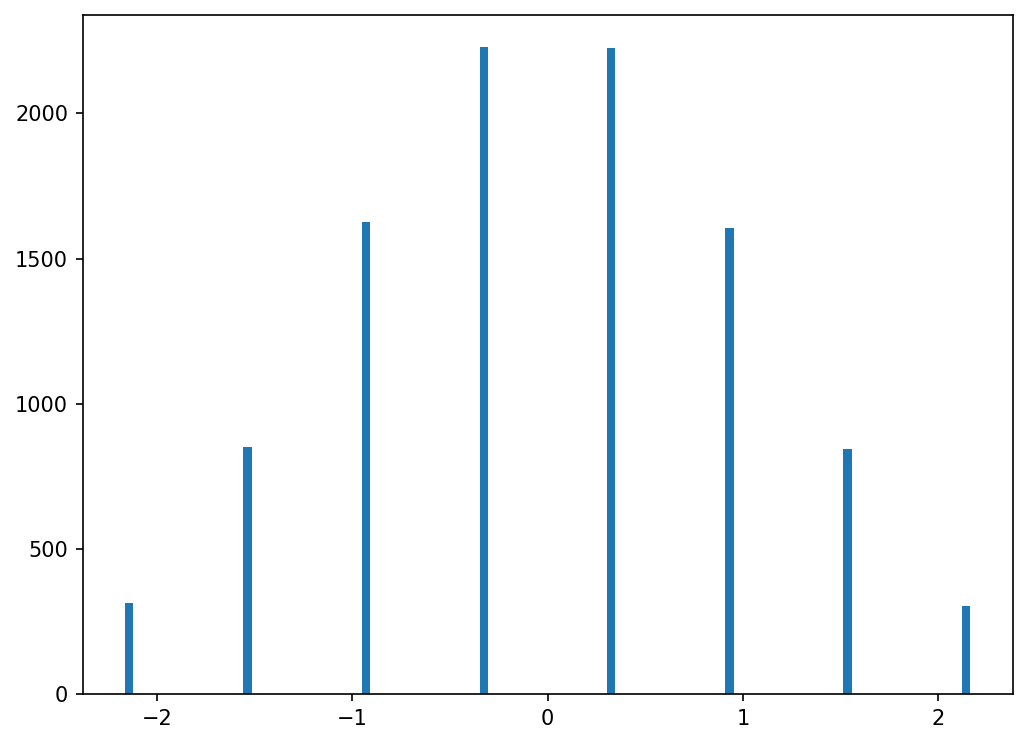

SNR:  10
epoch 0: Loss = -1.6794
epoch 500: Loss = -1.7254
epoch 1000: Loss = -1.7343
epoch 1500: Loss = -1.7311
epoch 2000: Loss = -1.7216
epoch 2500: Loss = -1.7247
epoch 3000: Loss = -1.7311
epoch 3500: Loss = -1.7153
probs:  tensor([0.0270, 0.0791, 0.1622, 0.2315, 0.2317, 0.1619, 0.0795, 0.0271],
       grad_fn=<SoftmaxBackward0>)


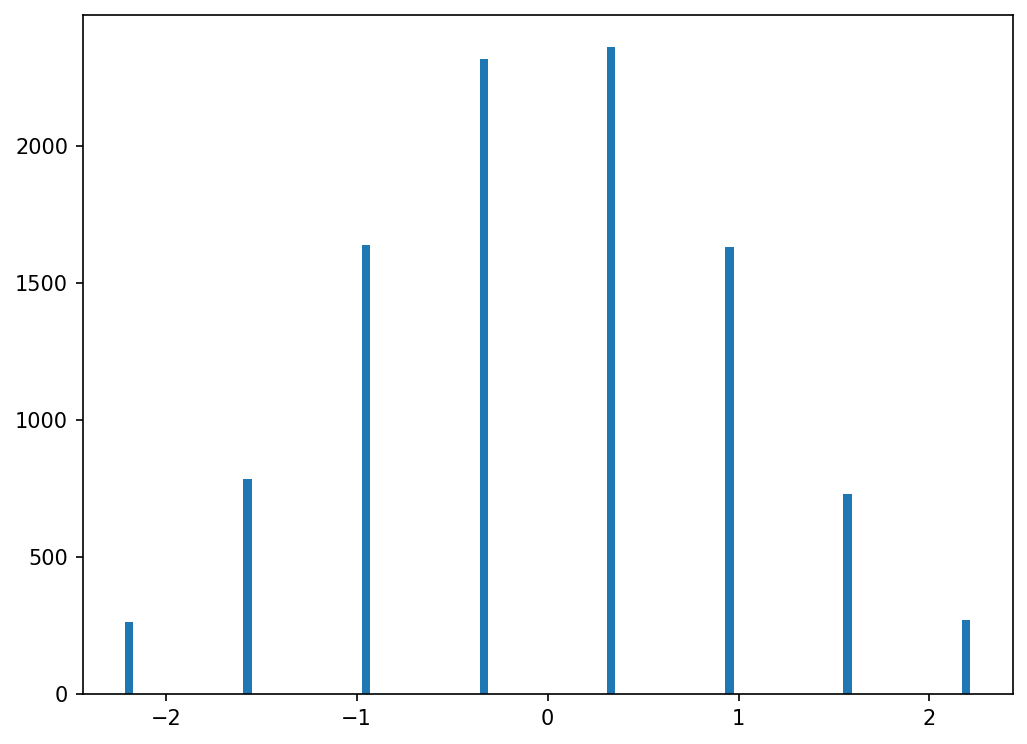

SNR:  11
epoch 0: Loss = -1.8420
epoch 500: Loss = -1.8589
epoch 1000: Loss = -1.8826
epoch 1500: Loss = -1.8743
epoch 2000: Loss = -1.8813
epoch 2500: Loss = -1.8796
epoch 3000: Loss = -1.8733
epoch 3500: Loss = -1.8619
probs:  tensor([0.0253, 0.0765, 0.1639, 0.2359, 0.2359, 0.1602, 0.0769, 0.0254],
       grad_fn=<SoftmaxBackward0>)


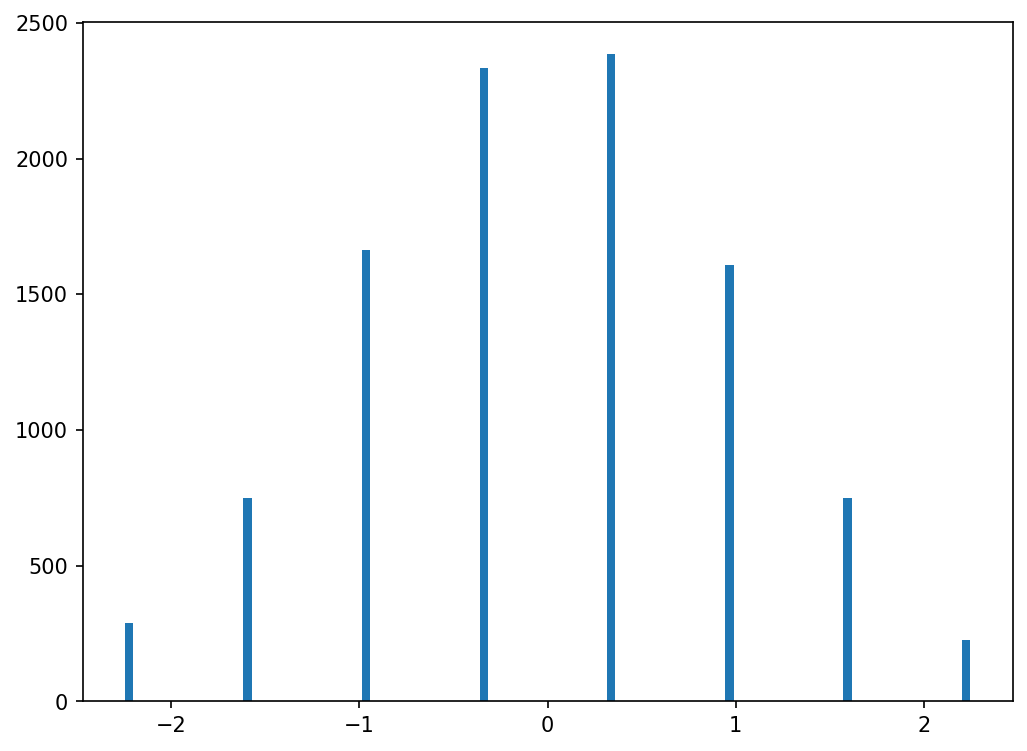

SNR:  12
epoch 0: Loss = -2.0083
epoch 500: Loss = -2.0322
epoch 1000: Loss = -2.0228
epoch 1500: Loss = -2.0186
epoch 2000: Loss = -2.0332
epoch 2500: Loss = -2.0222
epoch 3000: Loss = -2.0277
epoch 3500: Loss = -2.0262
probs:  tensor([0.0271, 0.0791, 0.1631, 0.2317, 0.2318, 0.1610, 0.0791, 0.0271],
       grad_fn=<SoftmaxBackward0>)


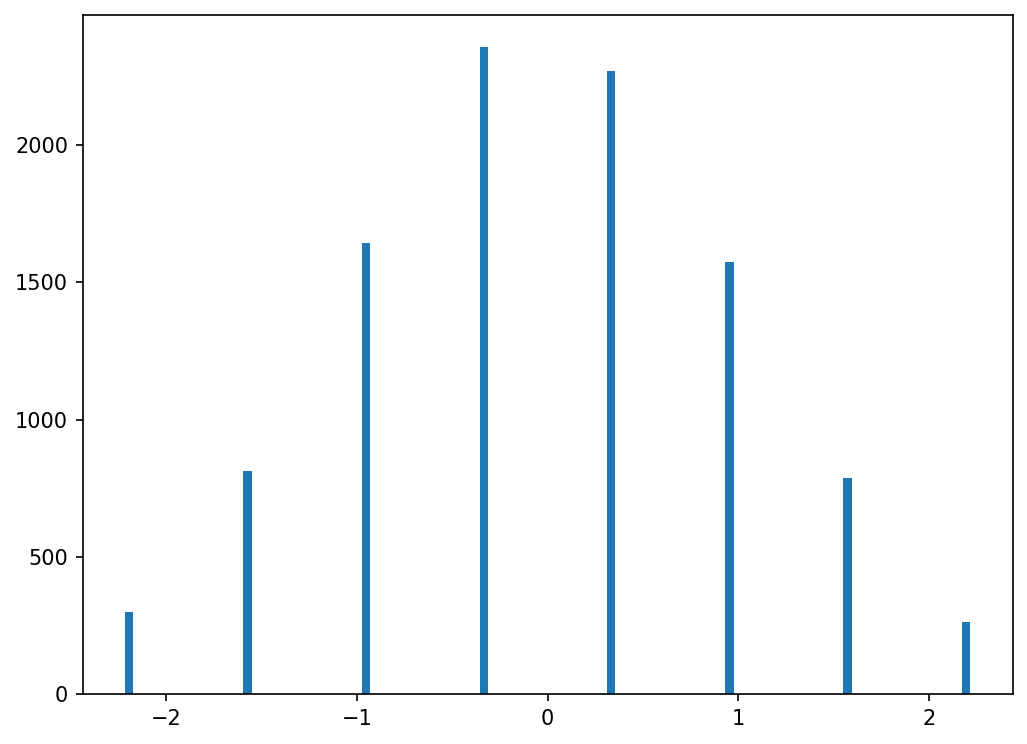

SNR:  13
epoch 0: Loss = -2.1460
epoch 500: Loss = -2.1508
epoch 1000: Loss = -2.1879
epoch 1500: Loss = -2.1696
epoch 2000: Loss = -2.1547
epoch 2500: Loss = -2.1738
epoch 3000: Loss = -2.1658
epoch 3500: Loss = -2.1675
probs:  tensor([0.0309, 0.0829, 0.1617, 0.2248, 0.2248, 0.1609, 0.0830, 0.0310],
       grad_fn=<SoftmaxBackward0>)


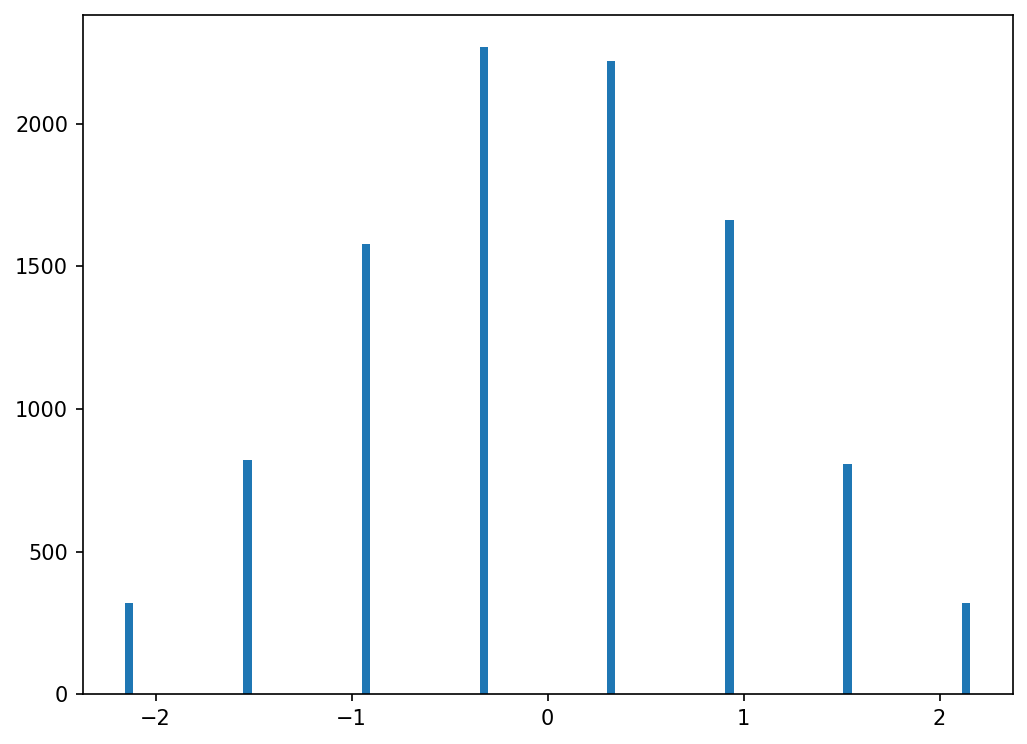

SNR:  14
epoch 0: Loss = -2.3066
epoch 500: Loss = -2.3131
epoch 1000: Loss = -2.3073
epoch 1500: Loss = -2.3223
epoch 2000: Loss = -2.3078
epoch 2500: Loss = -2.3215
epoch 3000: Loss = -2.3055
epoch 3500: Loss = -2.3040
probs:  tensor([0.0372, 0.0888, 0.1597, 0.2141, 0.2141, 0.1601, 0.0888, 0.0373],
       grad_fn=<SoftmaxBackward0>)


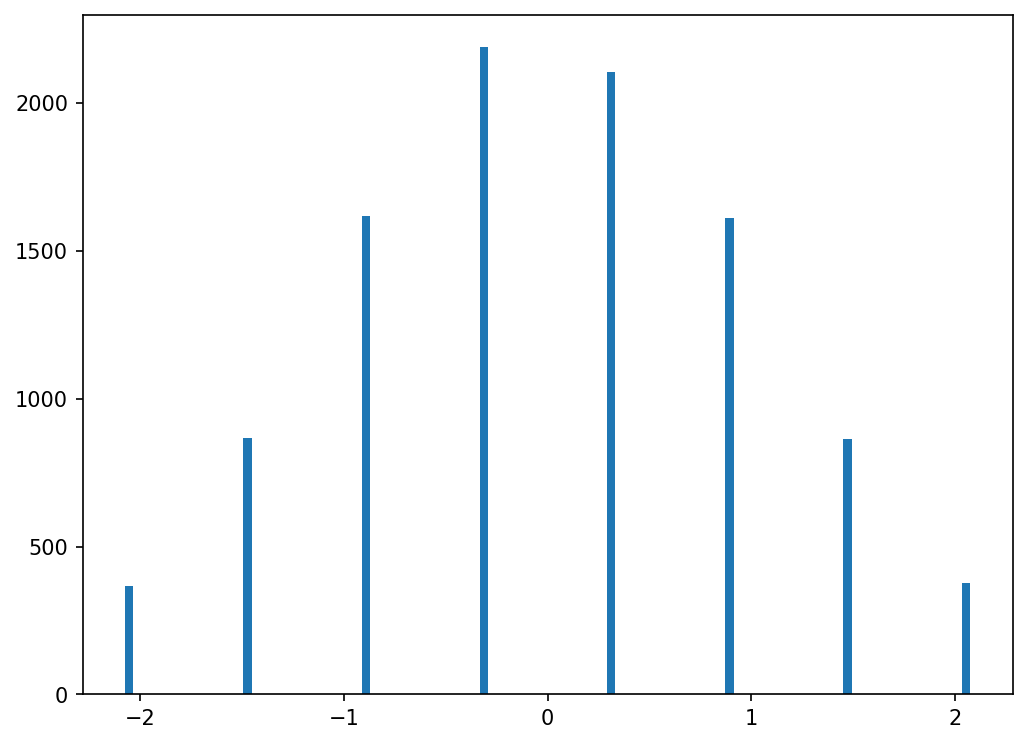

SNR:  15
epoch 0: Loss = -2.4296
epoch 500: Loss = -2.4498
epoch 1000: Loss = -2.4452
epoch 1500: Loss = -2.4524
epoch 2000: Loss = -2.4474
epoch 2500: Loss = -2.4631
epoch 3000: Loss = -2.4518
epoch 3500: Loss = -2.4452
probs:  tensor([0.0453, 0.0949, 0.1570, 0.2023, 0.2024, 0.1575, 0.0952, 0.0454],
       grad_fn=<SoftmaxBackward0>)


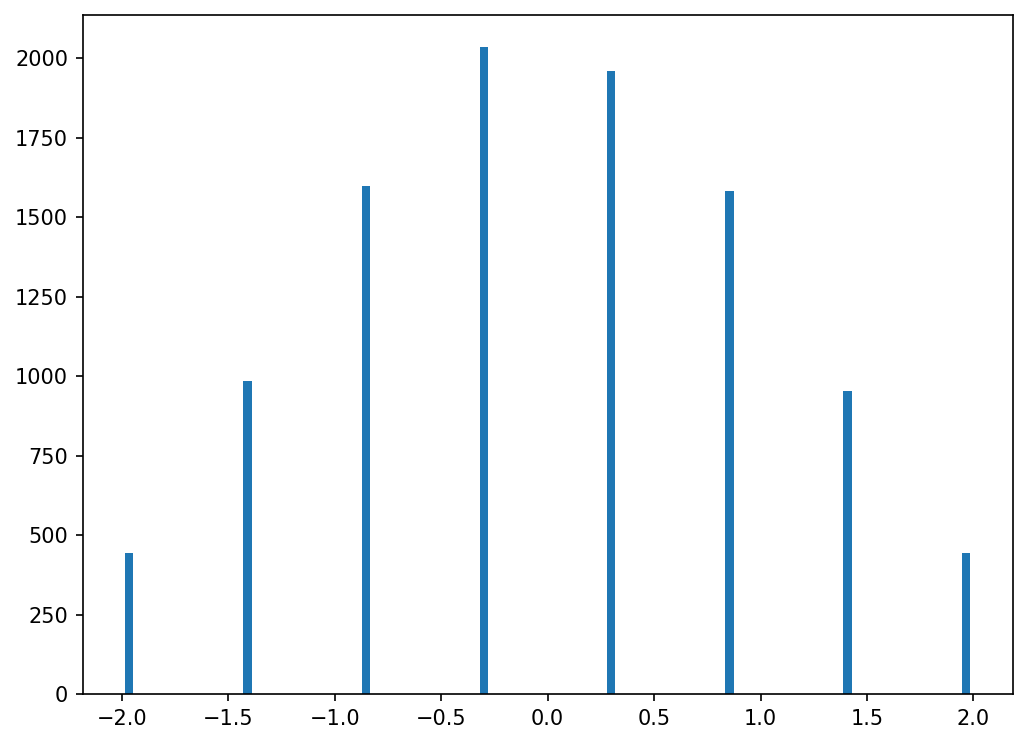

SNR:  16
epoch 0: Loss = -2.5588
epoch 500: Loss = -2.5780
epoch 1000: Loss = -2.5822
epoch 1500: Loss = -2.5830
epoch 2000: Loss = -2.5671
epoch 2500: Loss = -2.5571
epoch 3000: Loss = -2.5594
epoch 3500: Loss = -2.5735
probs:  tensor([0.0549, 0.1014, 0.1540, 0.1895, 0.1895, 0.1543, 0.1015, 0.0549],
       grad_fn=<SoftmaxBackward0>)


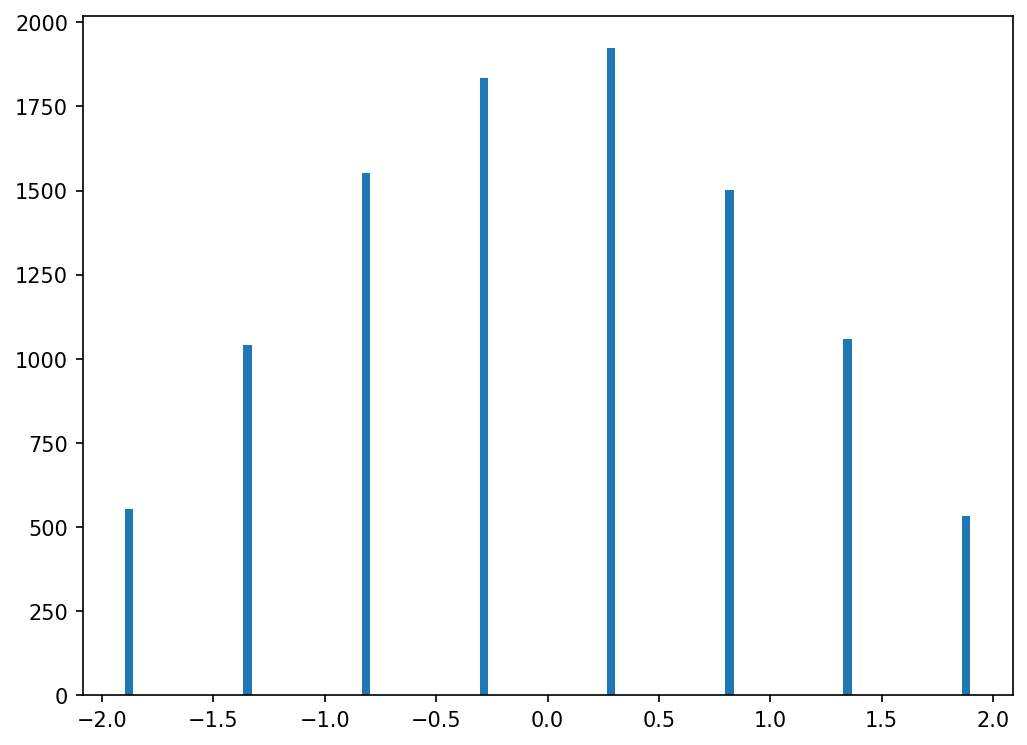

SNR:  17
epoch 0: Loss = -2.6677
epoch 500: Loss = -2.6692
epoch 1000: Loss = -2.6812
epoch 1500: Loss = -2.6937
epoch 2000: Loss = -2.6805
epoch 2500: Loss = -2.6737
epoch 3000: Loss = -2.6773
epoch 3500: Loss = -2.6795
probs:  tensor([0.0663, 0.1076, 0.1497, 0.1764, 0.1764, 0.1497, 0.1075, 0.0663],
       grad_fn=<SoftmaxBackward0>)


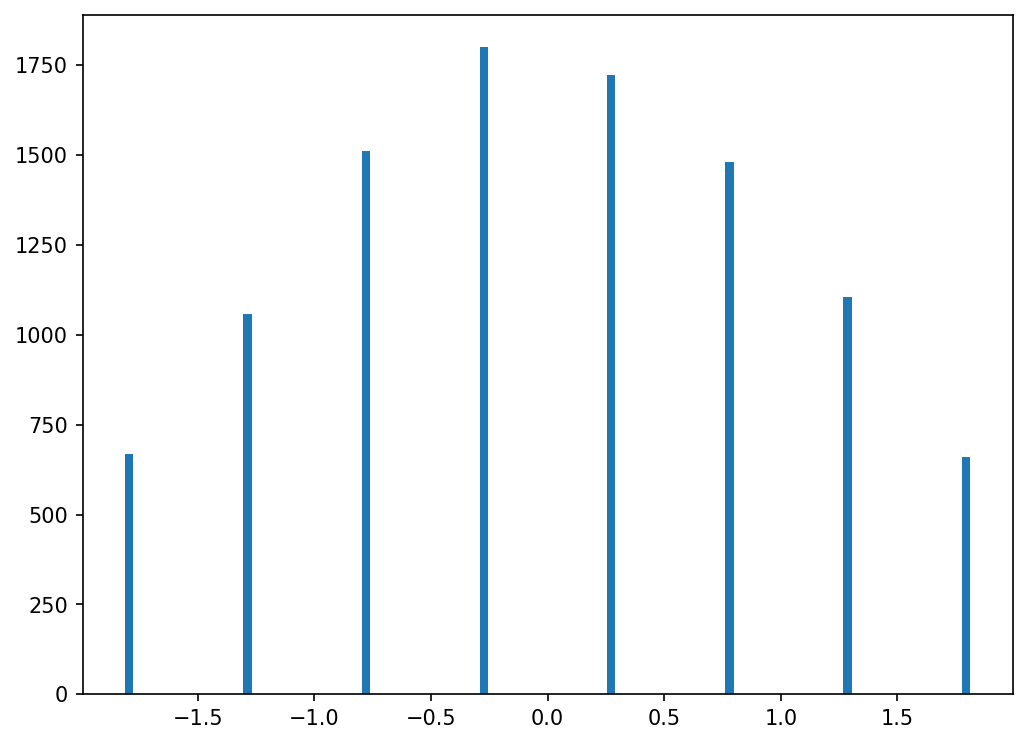

SNR:  18
epoch 0: Loss = -2.7729
epoch 500: Loss = -2.7638
epoch 1000: Loss = -2.7782
epoch 1500: Loss = -2.7857
epoch 2000: Loss = -2.7815
epoch 2500: Loss = -2.7831
epoch 3000: Loss = -2.7905
epoch 3500: Loss = -2.7705
probs:  tensor([0.0769, 0.1124, 0.1453, 0.1652, 0.1652, 0.1454, 0.1126, 0.0770],
       grad_fn=<SoftmaxBackward0>)


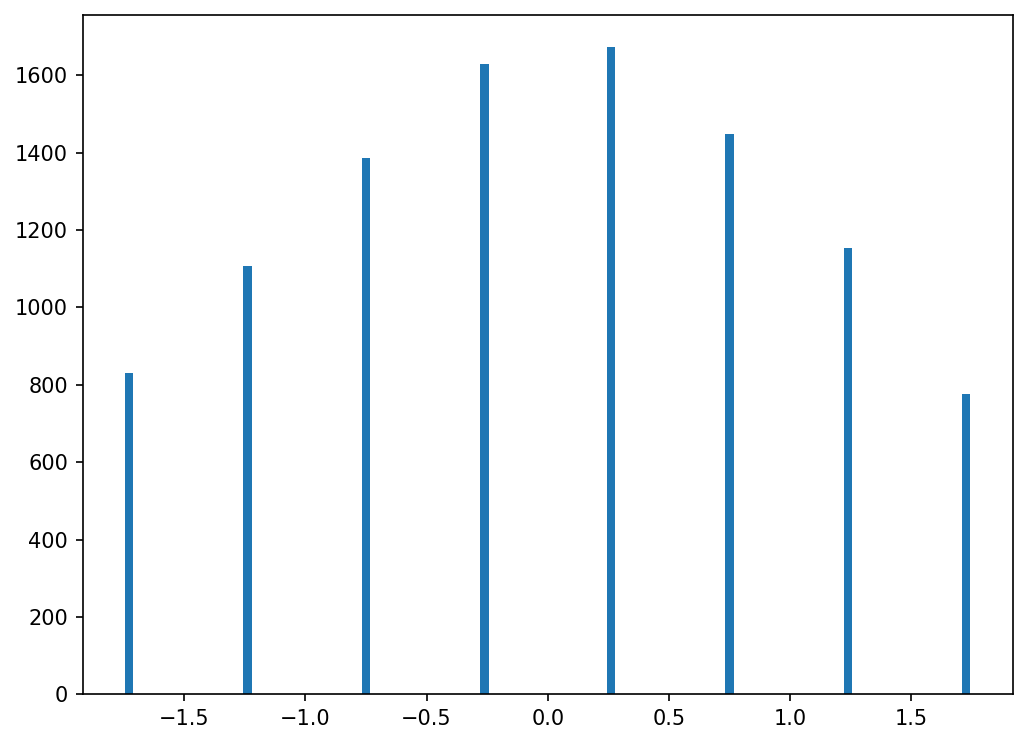

SNR:  19
epoch 0: Loss = -2.8445
epoch 500: Loss = -2.8546
epoch 1000: Loss = -2.8546
epoch 1500: Loss = -2.8503
epoch 2000: Loss = -2.8471
epoch 2500: Loss = -2.8526
epoch 3000: Loss = -2.8597
epoch 3500: Loss = -2.8591
probs:  tensor([0.0887, 0.1167, 0.1407, 0.1543, 0.1542, 0.1405, 0.1164, 0.0886],
       grad_fn=<SoftmaxBackward0>)


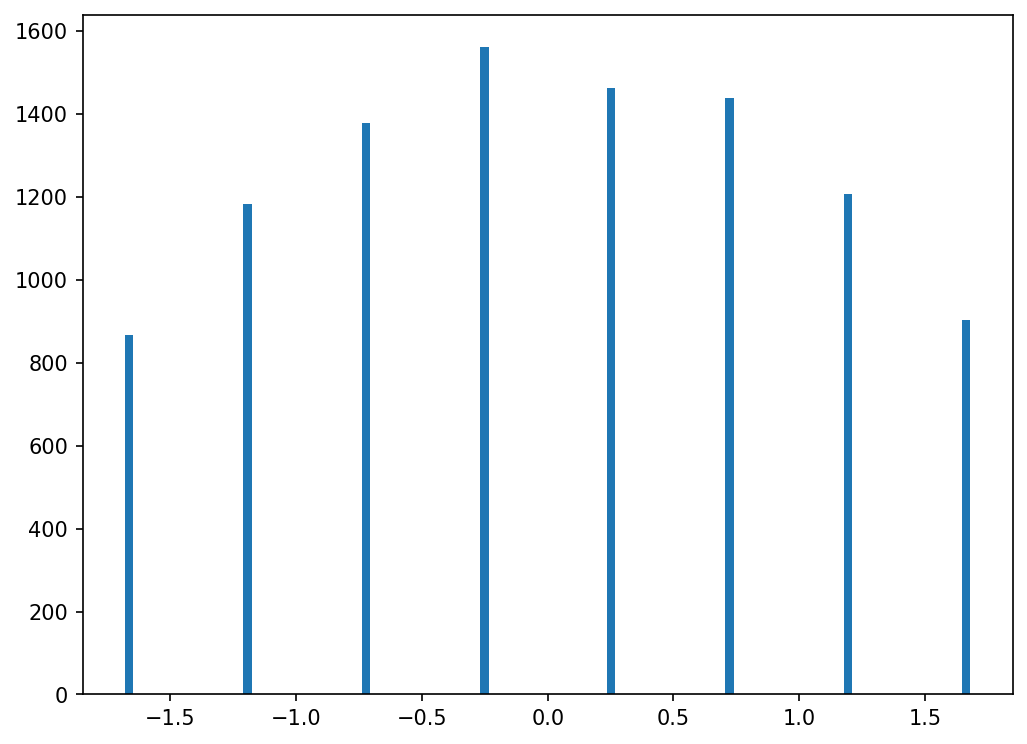

SNR:  20
epoch 0: Loss = -2.9067
epoch 500: Loss = -2.9150
epoch 1000: Loss = -2.9138
epoch 1500: Loss = -2.9227
epoch 2000: Loss = -2.9181
epoch 2500: Loss = -2.9140
epoch 3000: Loss = -2.9174
epoch 3500: Loss = -2.9144
probs:  tensor([0.0989, 0.1198, 0.1362, 0.1452, 0.1452, 0.1361, 0.1195, 0.0990],
       grad_fn=<SoftmaxBackward0>)


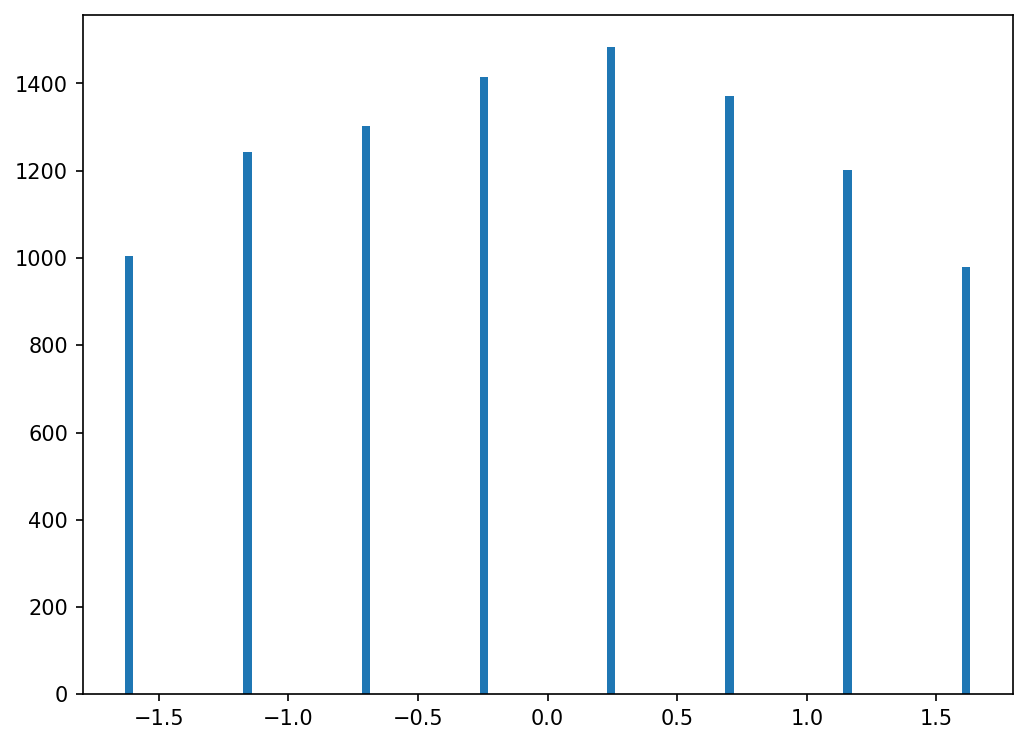

SNR:  21
epoch 0: Loss = -2.9495
epoch 500: Loss = -2.9488
epoch 1000: Loss = -2.9550
epoch 1500: Loss = -2.9527
epoch 2000: Loss = -2.9560
epoch 2500: Loss = -2.9541
epoch 3000: Loss = -2.9588
epoch 3500: Loss = -2.9589
probs:  tensor([0.1087, 0.1221, 0.1320, 0.1372, 0.1373, 0.1319, 0.1220, 0.1087],
       grad_fn=<SoftmaxBackward0>)


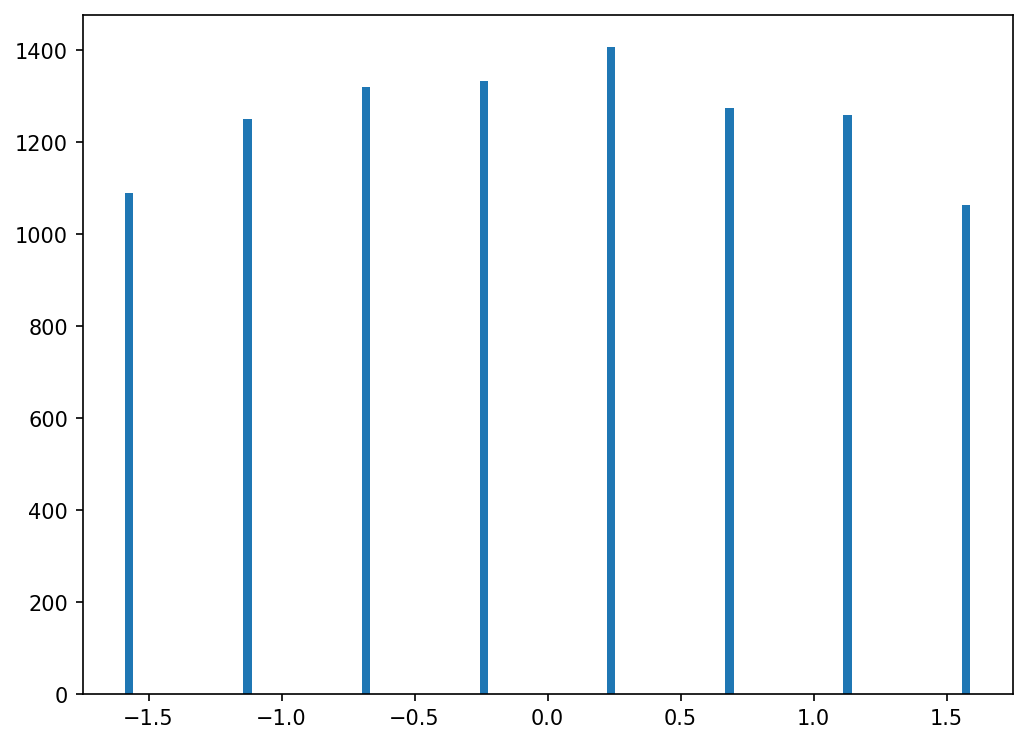

In [24]:
n = 10_000
SNR_dBs = np.arange(5,22)
M = 8
alphabet = np.arange(-7,8,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols = alphabet[indices]

mi_64 = []
mi_pas = []
for snrdB in SNR_dBs:
    print('SNR: ', snrdB)
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2
    y = AWGN_channel_np(symbols, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_64.append(2*(3 - (xe) / np.log(2)))
    mi_pas.append(-2*(train_encoder_at_dB(snrdB, report=True)).detach().numpy().tolist()/np.log(2))

In [25]:
print(mi_pas)

[2.039912019281403, 2.2781547700074274, 2.5452696241949986, 2.8391315642100556, 3.152821040077784, 3.4672197723976708, 3.7268633562664597, 4.0619753350909615, 4.337725782143656, 4.605979161479939, 4.876773068534767, 5.14192078516177, 5.38382229480225, 5.548147246152741, 5.701999485961593, 5.813316976559054, 5.9123535300237045]


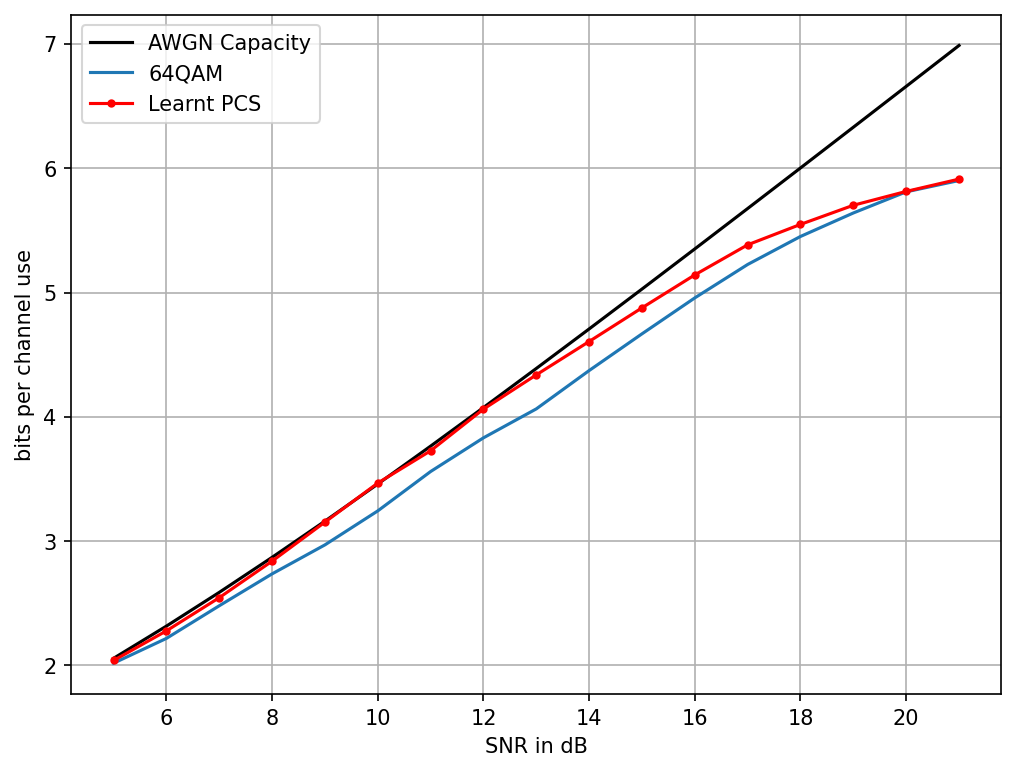

In [26]:
# Plot
plt.rcParams['figure.figsize'] = [8, 6]

plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='AWGN Capacity')
plt.plot(SNR_dBs, mi_64, label = '64QAM')

plt.plot(SNR_dBs, mi_pas, color='red', marker='o', markersize=3, label='Learnt PCS')
# for xy in zip(SNR_dBs, mi_pas):
#    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.legend()
plt.grid()
plt.ylabel('bits per channel use')
plt.xlabel('SNR in dB')
tikzplotlib.save("stark_tikz.tex")